# Surrogate Ensemble Modeling for Dynamic Climate Impact Models

Introduction

Libraries

In [1]:
import numpy as np
import pandas as pd

from utils import plotting

%load_ext autoreload
%autoreload 2

### Seaonal forecasts ensembles

### Malaria modeling

### Dataset

In [2]:
dataset = 'forecast and query loop clim and R0 2017-2021.csv'

In [3]:
df = pd.read_csv('datasets/'+dataset)
df.head()

,month,day,year,forecast,Precip_layer,Temp_layer,precip,temp,datetime,P,gono_len,sporo_len,mosquitoes,R0
0,1,1,2017,1,50686,50685,0.576628,17.865900,2017-01-01,0.904054,5.173293,1000.000000,0.000000,0.000000e+00
1,1,1,2018,1,50686,50685,0.166432,18.287195,2018-01-01,0.902434,4.983980,386.497216,0.576628,3.811930e-18
2,1,1,2019,1,50686,50685,1.760069,19.013910,2019-01-01,0.898305,4.694860,109.477182,0.891898,8.634740e-06
3,1,1,2020,1,50686,50685,0.000000,16.801691,2020-01-01,0.905616,5.742562,1000.000000,1.635573,1.264950e-43
4,1,1,2021,1,50686,50685,0.950271,17.495355,2021-01-01,0.905009,5.355321,1000.000000,2.106984,9.517402e-44


In [4]:
def preprocess(data):
    
    data['date'] = pd.to_datetime(data['datetime'])
    data['month'] = data['date'].dt.month.astype(int)
    data['day_of_month'] = data['date'].dt.day.astype(int)
    data['season'] = np.where(data['month'].between(1, 6),"Spring","Fall")
    
    #data = data[columns]

    return data

In [5]:
df = preprocess(df)
df.head()

,month,day,year,forecast,Precip_layer,Temp_layer,precip,temp,datetime,P,gono_len,sporo_len,mosquitoes,R0,date,day_of_month,season
0,1,1,2017,1,50686,50685,0.576628,17.865900,2017-01-01,0.904054,5.173293,1000.000000,0.000000,0.000000e+00,2017-01-01,1,Spring
1,1,1,2018,1,50686,50685,0.166432,18.287195,2018-01-01,0.902434,4.983980,386.497216,0.576628,3.811930e-18,2018-01-01,1,Spring
2,1,1,2019,1,50686,50685,1.760069,19.013910,2019-01-01,0.898305,4.694860,109.477182,0.891898,8.634740e-06,2019-01-01,1,Spring
3,1,1,2020,1,50686,50685,0.000000,16.801691,2020-01-01,0.905616,5.742562,1000.000000,1.635573,1.264950e-43,2020-01-01,1,Spring
4,1,1,2021,1,50686,50685,0.950271,17.495355,2021-01-01,0.905009,5.355321,1000.000000,2.106984,9.517402e-44,2021-01-01,1,Spring


### Surrogate training

In [6]:
split = "split-by-year"
train_ensembles = 0.7

train_years = [2017, 2018, 2019, 2020]
test_years = [2021]

features = ['day_of_month', 'month', 'precip', 'temp'] #,'R0']
target   = ['R0']

quantiles = [0.1587, 0.50, 0.8413]
labels = ['R0 lower', 'R0 mean', 'R0 upper']

"""
if split == "split-by-year":
    df1 = resample_df[resample_df['year'] <  2021].copy()
    df2 = resample_df[resample_df['year'] == 2021].copy()
elif split == "split-by-ensemble":
    train_split = 0.7
    members = data['forecast'].unique()
    train_idxs = members[:int(train_split*len(members))]
    test_idxs = members[int(train_split*len(members)):]
"""

'\nif split == "split-by-year":\n    df1 = resample_df[resample_df[\'year\'] <  2021].copy()\n    df2 = resample_df[resample_df[\'year\'] == 2021].copy()\nelif split == "split-by-ensemble":\n    train_split = 0.7\n    members = data[\'forecast\'].unique()\n    train_idxs = members[:int(train_split*len(members))]\n    test_idxs = members[int(train_split*len(members)):]\n'

In [7]:
from sklearn.preprocessing import StandardScaler

def scale_data(data, train_years, test_years, features, target):
    
    df_train = data[data['year'].isin(train_years)].copy()
    
    # Fit Scaler only on Training features
    feature_scaler = StandardScaler()
    feature_scaler.fit(df_train[features].values)
    # Fit Scaler only on Training target values
    target_scaler = StandardScaler()
    target_scaler.fit(df_train[target].values)

    # Transfom on both Training and Test data
    data_values = data[features].values.copy()
    data = data.drop(columns=(features))
    data = data.join(pd.DataFrame(feature_scaler.transform(data_values),
                                  columns=features))
    return data, feature_scaler, target_scaler

def select_sliding_data(data, features, target, sequence_length):
    X_list, y_list = [], []
    idxs_selection = pd.Index([])
    for iyear in data['year'].unique():
        data_yearly = data[data['year']==iyear].copy()
        for iseason in data_yearly['season'].unique():
            data_seasonal = data_yearly[data_yearly['season']==iseason].copy()
            for iforecast in data_seasonal['forecast'].unique():
                idata_X = data_seasonal[data_seasonal['forecast']==iforecast][features].values
                idata_y = data_seasonal[data_seasonal['forecast']==iforecast][target].values
                for ii in range(len(idata_X)):
                    if (ii+sequence_length-1) < len(idata_X):              ### if -1: predict for last timestamp in sequence
                        X_list.append(idata_X[ii:ii+sequence_length, :])
                        y_list.append(idata_y[ii+sequence_length-1])       ### if -1: predict for last timestamp in sequence
                idxs_selection = idxs_selection.union(data_seasonal[data_seasonal['forecast']==iforecast].iloc[sequence_length:].index, sort=False)
    return(np.array(X_list), np.squeeze(np.array(y_list)), idxs_selection)

In [8]:
df_scaled, feature_scaler, target_scaler = scale_data(df.copy(), train_years, test_years, features, target)
#df_scaled = df.copy()

sequence_length = 50

df_train_scaled = df_scaled[df_scaled['year'].isin(train_years)].copy()
df_test_scaled = df_scaled[df_scaled['year'].isin(test_years)].copy()

X_train, y_train, idxs_train = select_sliding_data(df_train_scaled, features, target, sequence_length)
X_test, y_test, idxs_test = select_sliding_data(df_test_scaled, features, target, sequence_length)

df_test = df[['date', 'forecast', 'season', 'R0']].iloc[idxs_test].copy()

In [9]:
np.shape(X_test)

(13350, 50, 4)

## BLSTM

In [ ]:
## Model training

from models.BLSTM import train_blstm

n_features = len(features)
output_length = 1
batch_size = 4096
n_epochs = 200
learning_rate = 0.01
n_experiments = 200
load_model = None #'BLSTM_train2017-2020_predict2021_e200_t0-01_seq50_feat5_bs4096.pth'

y_pred = train_blstm(X_train, y_train, X_test, n_features, output_length, batch_size, n_epochs, learning_rate, sequence_length, n_experiments, target_scaler, save_model=True)

Training model ... Epochs:  69%|██████▉   | 138/200 [7:36:31<3:48:49, 221.44s/it, loss=0.000522] 

In [325]:
['R0_'+str(i) for i in range(n_experiments)]

['R0_0',
 'R0_1',
 'R0_2',
 'R0_3',
 'R0_4',
 'R0_5',
 'R0_6',
 'R0_7',
 'R0_8',
 'R0_9',
 'R0_10',
 'R0_11',
 'R0_12',
 'R0_13',
 'R0_14',
 'R0_15',
 'R0_16',
 'R0_17',
 'R0_18',
 'R0_19',
 'R0_20',
 'R0_21',
 'R0_22',
 'R0_23',
 'R0_24',
 'R0_25',
 'R0_26',
 'R0_27',
 'R0_28',
 'R0_29',
 'R0_30',
 'R0_31',
 'R0_32',
 'R0_33',
 'R0_34',
 'R0_35',
 'R0_36',
 'R0_37',
 'R0_38',
 'R0_39',
 'R0_40',
 'R0_41',
 'R0_42',
 'R0_43',
 'R0_44',
 'R0_45',
 'R0_46',
 'R0_47',
 'R0_48',
 'R0_49',
 'R0_50',
 'R0_51',
 'R0_52',
 'R0_53',
 'R0_54',
 'R0_55',
 'R0_56',
 'R0_57',
 'R0_58',
 'R0_59',
 'R0_60',
 'R0_61',
 'R0_62',
 'R0_63',
 'R0_64',
 'R0_65',
 'R0_66',
 'R0_67',
 'R0_68',
 'R0_69',
 'R0_70',
 'R0_71',
 'R0_72',
 'R0_73',
 'R0_74',
 'R0_75',
 'R0_76',
 'R0_77',
 'R0_78',
 'R0_79',
 'R0_80',
 'R0_81',
 'R0_82',
 'R0_83',
 'R0_84',
 'R0_85',
 'R0_86',
 'R0_87',
 'R0_88',
 'R0_89',
 'R0_90',
 'R0_91',
 'R0_92',
 'R0_93',
 'R0_94',
 'R0_95',
 'R0_96',
 'R0_97',
 'R0_98',
 'R0_99',
 'R0_100',

In [183]:
y_pred_quantiles = []
for quantile, label in zip(quantiles, labels):
    print('Predicting '+label+' quantile:', quantile)
    y_pred_quantiles.append(y_pred.quantile(quantile, axis=1).values)


Predicting R0 lower quantile: 0.1587
Predicting R0 mean quantile: 0.5
Predicting R0 upper quantile: 0.8413


In [294]:
df_test_blstm = pd.concat([df_test.reset_index(), pd.DataFrame(np.array(y_pred_quantiles).T, columns=labels), y_pred], axis=1) 

In [296]:
df_test_blstm.to_csv('trained_models/blstm_train2017-2020_predict2021_e200_t0-01_seq50_feat5_bs4096_includeR0_predict51st_n-exp200_'+split+'.csv', index=False)

## RFQR

In [10]:
from models.RFQR import train_rfqr

random_state=0
min_samples_split=10
n_estimators=1000
n_jobs=8
verbose=True

y_pred_rfqr = train_rfqr(X_train, y_train, X_test, random_state, min_samples_split, n_estimators, n_jobs, verbose=True, save_model=True, load_model='RFQR_train2017-2020_predict2021.joblib')

ModuleNotFoundError: No module named 'sklearn.ensemble.forest'

In [299]:
df_test_rfqr = pd.concat([df_test.reset_index(), y_pred_rfqr], axis=1) 

In [301]:
for quantile, label in zip(quantiles, labels):
    df_test_rfqr[label] = target_scaler.inverse_transform(df_test_rfqr[label].values)
df_test_rfqr

,index,date,forecast,season,R0,R0 lower,R0 mean,R0 upper
0,254,2021-02-20,1,Spring,2.175977e-01,3.981895e-03,8.550661e-02,0.269875
1,259,2021-02-21,1,Spring,3.188942e-02,5.909443e-02,1.888823e-01,0.395686
2,264,2021-02-22,1,Spring,2.894879e-01,1.377270e-03,3.860231e-02,0.155538
3,269,2021-02-23,1,Spring,2.904540e-01,2.543593e-02,1.639861e-01,0.373767
4,274,2021-02-24,1,Spring,3.476634e-01,5.412234e-02,2.007201e-01,0.421069
...,...,...,...,...,...,...,...,...
13245,91279,2021-12-27,50,Fall,1.018973e-16,2.138107e-09,2.138107e-09,0.000001
13246,91284,2021-12-28,50,Fall,2.613944e-05,2.138107e-09,2.138107e-09,0.000157
13247,91289,2021-12-29,50,Fall,1.349285e-03,2.138107e-09,1.848235e-05,0.005887
13248,91294,2021-12-30,50,Fall,8.935732e-07,2.138107e-09,1.169308e-04,0.009279


In [302]:
df_test_rfqr.to_csv('trained_models/rfqr_train2017-2020_predict2021_e200_t0-01_seq50_feat5_bs4096_includeR0_predict51st_n-exp200_'+split+'.csv', index=False)

# Result visualization

              date variable     Value
0       2021-02-20     R0_0  0.033107
1       2021-02-21     R0_0  0.146184
2       2021-02-22     R0_0  0.026831
3       2021-02-23     R0_0  0.072520
4       2021-02-24     R0_0  0.058854
...            ...      ...       ...
2649995 2021-12-27   R0_199  0.001312
2649996 2021-12-28   R0_199 -0.019041
2649997 2021-12-29   R0_199  0.014994
2649998 2021-12-30   R0_199 -0.001176
2649999 2021-12-31   R0_199  0.013231

[2650000 rows x 3 columns]
0.7987924528301886


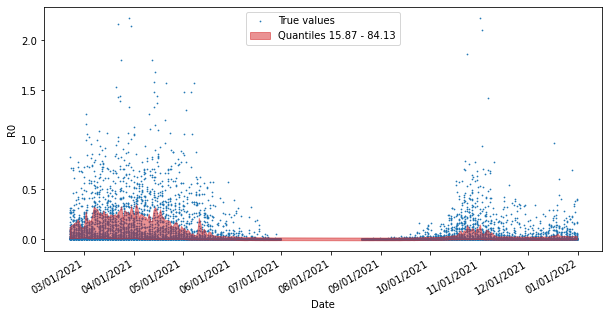

In [66]:
plotting.aggregate_ensembles_samples(test_df, 'figures/blstm_2021_agg_samples.pdf')

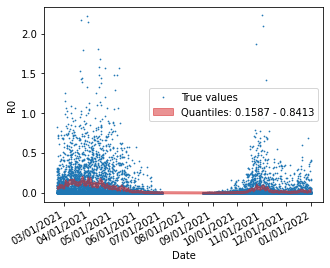

In [297]:
plotting.aggregate_ensembles(df_test_blstm, 'figures/blstm_2021_agg.pdf')

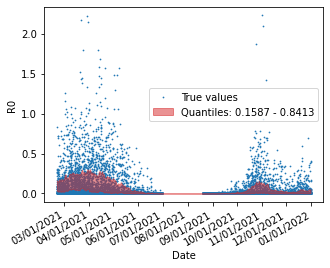

In [303]:
plotting.aggregate_ensembles(df_test_rfqr)

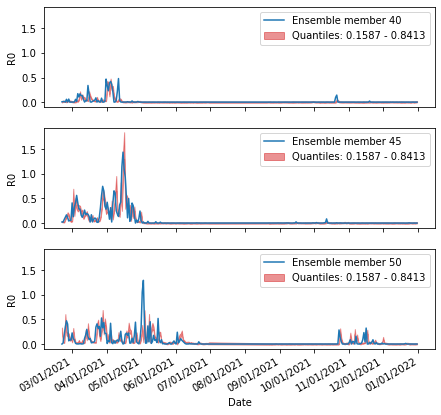

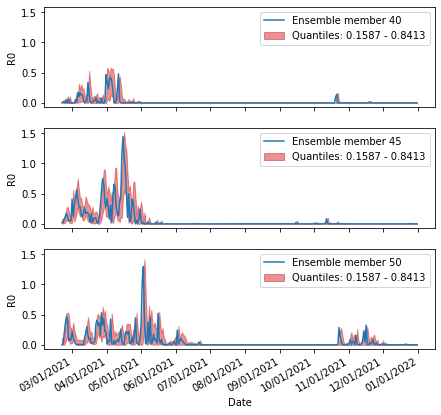

In [308]:
iforecasts = [40, 45, 50]
fig = plotting.plot_single_members(df_test_blstm, iforecasts, 'figures/blstm_2017-2021_iforecast.pdf')
fig = plotting.plot_single_members(df_test_rfqr, iforecasts, 'figures/rfqr_2017-2021_iforecast.pdf')

In [304]:
plotting.hit_rate(df_test_blstm, 'R0', 'R0 upper', 'R0 lower')

0.686566037735849

In [309]:
plotting.hit_rate(df_test_rfqr, 'R0', 'R0 upper', 'R0 lower')

0.3769056603773585

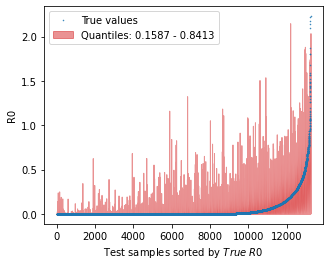

In [312]:
fig = plotting.plot_true_in_interval(df_test_rfqr, 'R0', 'figures/rfqr_2017-2021_interval.pdf')

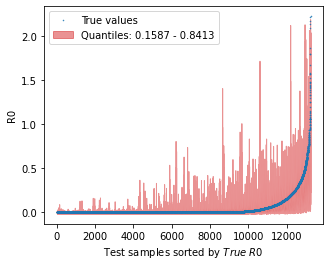

In [314]:
fig = plotting.plot_true_in_interval(df_test_blstm, 'R0', 'figures/blstm_2017-2021_interval.pdf')